<a href="https://colab.research.google.com/github/NombusoP/COMPUTATIONAL-DRUG-DISCOVERY/blob/main/CADD_hif1_bioactivity_data_preprocessing_and_Exploratory_data_Anlysis_P2_finale1m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMPUTATIONAL DRUG DISCOVERY P2


Exploratory data analysis

Import Libraries

In [ ]:
!pip install chembl_webresource_client

In [ ]:
!pip install rdkit

In [ ]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski


In [ ]:
targets_api=new_client.target
compounds_api=new_client.molecule
bioactivities_api=new_client.activity


get target data from ChEMBL,
get UniProt ID of the target

In [ ]:
uniprot_id='Q16665'

PDB:1H2M 
 HIF-1 in complex with HIF-1 alpha fragment peptide 
 HIF-1 alpha in cyan colour


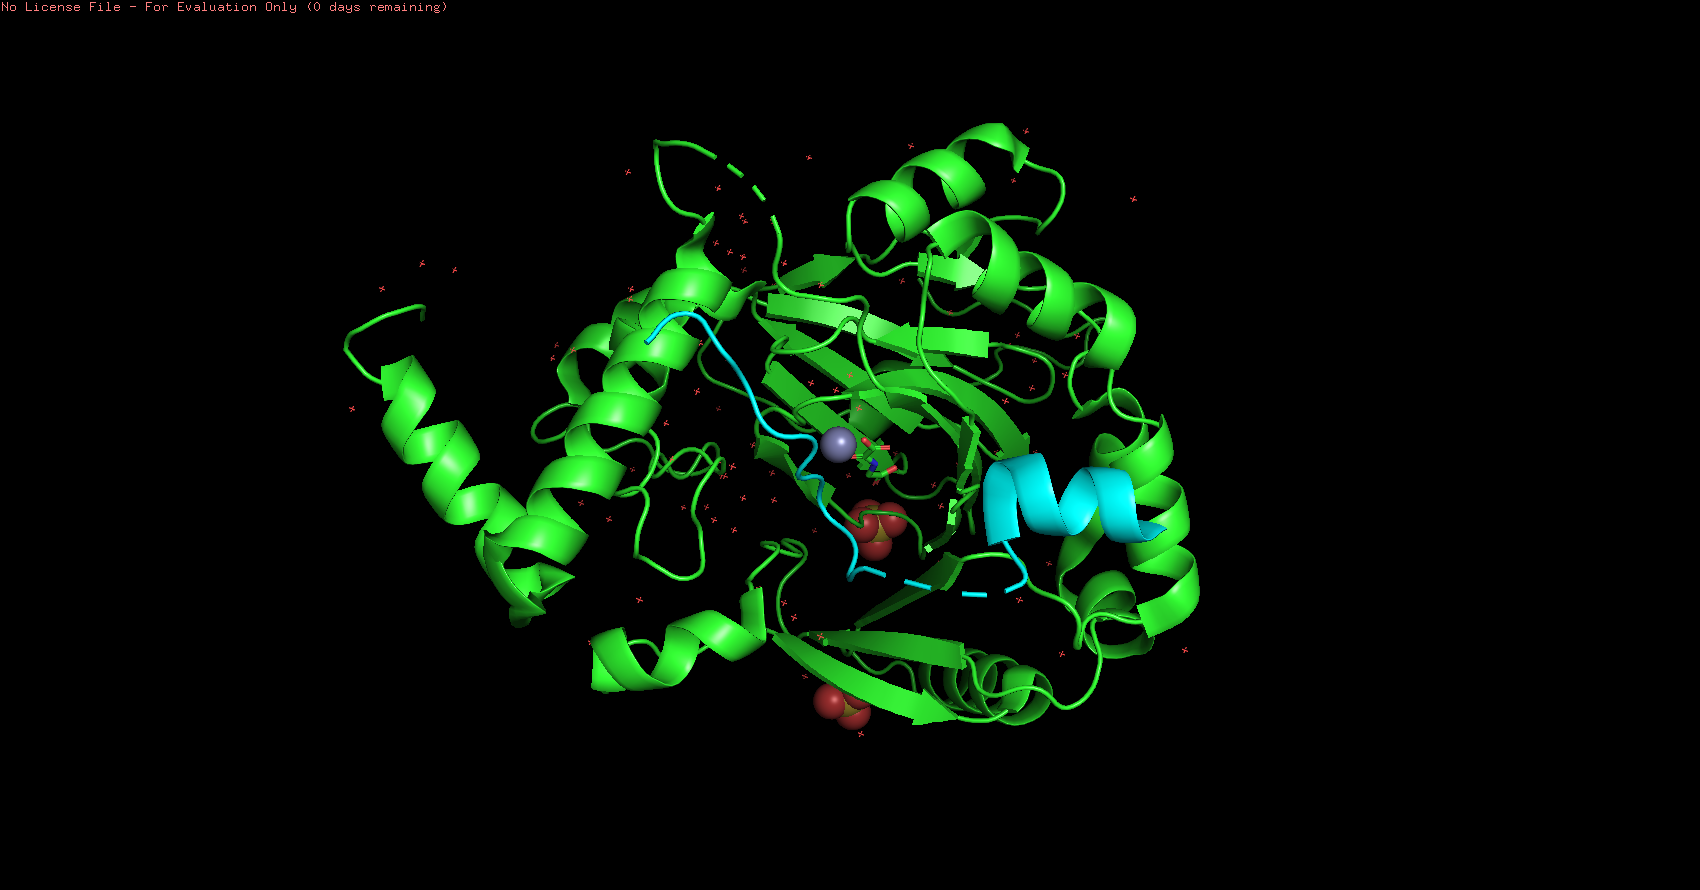

In [ ]:
from IPython.display import Image
print('PDB:1H2M','\n','HIF-1 in complex with HIF-1 alpha fragment peptide','\n','HIF-1 alpha in cyan colour')
Image(filename='1h2m.png',width=400,height=250)

In [ ]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


search and download Target protein

In [ ]:
target=new_client.target
target_query=target.search(' hypoxia inducible factor receptor')
targets=pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Q9NWT6', 'xref_name': None, 'xre...",Homo sapiens,Hypoxia-inducible factor 1-alpha inhibitor,32.0,False,CHEMBL5909,"[{'accession': 'Q9NWT6', 'component_descriptio...",SINGLE PROTEIN,9606.0
1,"[{'xref_id': 'Q16665', 'xref_name': None, 'xre...",Homo sapiens,Hypoxia-inducible factor 1 alpha,28.0,False,CHEMBL4261,"[{'accession': 'Q16665', 'component_descriptio...",SINGLE PROTEIN,9606.0
2,"[{'xref_id': 'Q61221', 'xref_name': None, 'xre...",Mus musculus,Hypoxia-inducible factor 1-alpha,28.0,False,CHEMBL6046,"[{'accession': 'Q61221', 'component_descriptio...",SINGLE PROTEIN,10090.0
3,[],Homo sapiens,Hypoxia-inducible factor prolyl hydroxylase,24.0,False,CHEMBL3831261,"[{'accession': 'Q96KS0', 'component_descriptio...",PROTEIN FAMILY,9606.0
4,"[{'xref_id': 'Q9NXG6', 'xref_name': None, 'xre...",Homo sapiens,Hypoxia-inducible factor prolyl 4-hydroxylase,23.0,False,CHEMBL3047,"[{'accession': 'Q9NXG6', 'component_descriptio...",SINGLE PROTEIN,9606.0
...,...,...,...,...,...,...,...,...,...
3488,[],Homo sapiens,VHL/Tyrosine-protein kinase Lck,0.0,False,CHEMBL4523727,"[{'accession': 'P06239', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606.0
3489,[],Homo sapiens,VHL/Tyrosine-protein kinase Yes,0.0,False,CHEMBL4523728,"[{'accession': 'P07947', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606.0
3490,[],Homo sapiens,VHL/SRC,0.0,False,CHEMBL4523733,"[{'accession': 'P12931', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606.0
3491,[],Homo sapiens,Src/Lck kinase,0.0,False,CHEMBL4523978,"[{'accession': 'P12931', 'component_descriptio...",SELECTIVITY GROUP,9606.0


Select the target (target ChEMBL ID)

In [ ]:
selected_target=targets.target_chembl_id[1]
print('Target ChEMBL ID is :',selected_target)

Target ChEMBL ID is : CHEMBL4261


 information on the selected target

In [ ]:
target=targets.iloc[1]
target

cross_references      [{'xref_id': 'Q16665', 'xref_name': None, 'xre...
organism                                                   Homo sapiens
pref_name                              Hypoxia-inducible factor 1 alpha
score                                                              28.0
species_group_flag                                                False
target_chembl_id                                             CHEMBL4261
target_components     [{'accession': 'Q16665', 'component_descriptio...
target_type                                              SINGLE PROTEIN
tax_id                                                           9606.0
Name: 1, dtype: object

save the selcted ChEMBL ID

In [ ]:
chembl_id=target.target_chembl_id
print('the selected ChEMBL ID is:',chembl_id)

the selected ChEMBL ID is: CHEMBL4261


OBTAIN BIOACTIVITY DATA( which is reported as IC50 values in nM)

-get bioactivity data for the target (Hypoxia-inducible factor 1 alpha)

-obtain bioactity data including the following:

-human proteins

-bioactivity type IC50

exact measurement(relation'=')

binding assays (assay type 'B')

In [ ]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B",
).only(

    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of bioactivities object: 13, <class 'dict'>


{'activity_id': 2007500,
 'assay_chembl_id': 'CHEMBL901549',
 'assay_description': 'Inhibition of hypoxia-induced HIF1 activation in human T47D cells after 16 hrs by cell based luciferase assay',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL235553',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '820.0',
 'target_chembl_id': 'CHEMBL4261',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.82'}

bioactivity data of the above columns contain the following information

Download bioactivty data from ChEMBL in a pandas DF format

In [ ]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (413, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,2007500,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL235553,=,nM,820.0,CHEMBL4261,Homo sapiens,IC50,uM,0.82
1,2007503,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL391152,=,nM,3400.0,CHEMBL4261,Homo sapiens,IC50,uM,3.4
2,2048473,CHEMBL924308,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL333985,=,nM,2000.0,CHEMBL4261,Homo sapiens,IC50,uM,2.0
3,2048474,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL399636,=,nM,1030.0,CHEMBL4261,Homo sapiens,IC50,uM,1.03
4,2048476,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL401390,=,nM,11900.0,CHEMBL4261,Homo sapiens,IC50,uM,11.9


columns , standard_units and units have the same entry

-standard_value/value columns also have the same entry,

-in this case ChEMBL standardised  column will be used , thus dropping values and units columns







checking  'units' column whether the value measurements in this column are the similar(uniform)

In [ ]:
bioactivities_df['units'].unique()

array(['uM', 'nM', 'umol', 'nmol', 'umol/L'], dtype=object)

In [ ]:
bioactivities_df.shape

(413, 13)

dropping 'values' and 'units' columns

In [ ]:

bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2007500,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL235553,=,nM,820.0,CHEMBL4261,Homo sapiens,IC50
1,2007503,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL391152,=,nM,3400.0,CHEMBL4261,Homo sapiens,IC50
2,2048473,CHEMBL924308,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL333985,=,nM,2000.0,CHEMBL4261,Homo sapiens,IC50
3,2048474,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL399636,=,nM,1030.0,CHEMBL4261,Homo sapiens,IC50
4,2048476,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL401390,=,nM,11900.0,CHEMBL4261,Homo sapiens,IC50


also check the column 'type' which holds the IC50 data,

-check if  this bioactivity data is ONLY recorded as IC50

In [ ]:
bioactivities_df['type'].unique()

array(['IC50'], dtype=object)

PREPROCESS AND FILTER BIOACTIVITY DATA

1.convert datatype for  standard_values column from object dtype  to float dtype

-standard_value contains standardised(IC50) values.

-to use the values for subsequent calculations and analysis ,

convert values to float dtype

In [ ]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [ ]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

check whether the standard_value dtype is now a float

In [ ]:
bioactivities_df['standard_value'].dtypes

dtype('float64')

columns information

In [ ]:
bioactivities_df.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'type'],
      dtype='object')

check and delete entries with missing values

-check all missing values reported as 'NA',  ' ', np.NaN, None

-can aslo use isnull () function to checking for any missing values


In [ ]:
missing_values=['NA','',np.NaN,None]
missing=bioactivities_df.isin(missing_values)
print(missing)

     activity_id  assay_chembl_id  assay_description  assay_type  \
0          False            False              False       False   
1          False            False              False       False   
2          False            False              False       False   
3          False            False              False       False   
4          False            False              False       False   
..           ...              ...                ...         ...   
408        False            False              False       False   
409        False            False              False       False   
410        False            False              False       False   
411        False            False              False       False   
412        False            False              False       False   

     molecule_chembl_id  relation  standard_units  standard_value  \
0                 False     False           False           False   
1                 False     False           F

In [ ]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (413, 11)


checking shape of DF, number of rows and columns

In [ ]:
bioactivities_df.shape

(413, 11)

In [ ]:
number_rows,number_columns=bioactivities_df.shape
print('number of rows:',number_rows,'\n','number of columns:',number_columns)

number of rows: 413 
 number of columns: 11


create heatmap to check for missing data

<Axes: >

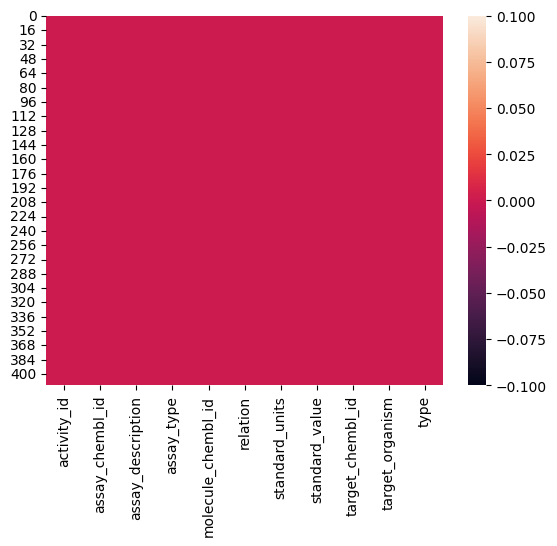

In [ ]:
sns.heatmap(bioactivities_df.isnull())

In [ ]:
bioactivities_df.isnull().sum()

activity_id           0
assay_chembl_id       0
assay_description     0
assay_type            0
molecule_chembl_id    0
relation              0
standard_units        0
standard_value        0
target_chembl_id      0
target_organism       0
type                  0
dtype: int64

3. keep entries with standard_unit=='nM' unit measurement


In [ ]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


check if the standard_units column has only nM entries,
-check DF shape i.e number of rows and columns

In [ ]:
bioactivities_df['standard_units'].unique()

array(['nM'], dtype=object)

In [ ]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [ ]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (413, 11)


drop  duplicate entries

-keep first entries of the same molecule_chembl_id,

-check DF shape

In [ ]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (367, 11)


In [ ]:
number_rows,number_columns=bioactivities_df.shape
print('number of rows:',number_rows,'\n','number of columns:',number_columns)

number of rows: 367 
 number of columns: 11


rename DF

In [ ]:
hif_bioactivities_df2a=bioactivities_df
hif_bioactivities_df2a.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2007500,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL235553,=,nM,820.0,CHEMBL4261,Homo sapiens,IC50
1,2007503,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL391152,=,nM,3400.0,CHEMBL4261,Homo sapiens,IC50
2,2048473,CHEMBL924308,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL333985,=,nM,2000.0,CHEMBL4261,Homo sapiens,IC50
3,2048474,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL399636,=,nM,1030.0,CHEMBL4261,Homo sapiens,IC50
4,2048476,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL401390,=,nM,11900.0,CHEMBL4261,Homo sapiens,IC50


In [ ]:
hif_bioactivities_df2a.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2007500,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL235553,=,nM,820.0,CHEMBL4261,Homo sapiens,IC50
1,2007503,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL391152,=,nM,3400.0,CHEMBL4261,Homo sapiens,IC50
2,2048473,CHEMBL924308,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL333985,=,nM,2000.0,CHEMBL4261,Homo sapiens,IC50
3,2048474,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL399636,=,nM,1030.0,CHEMBL4261,Homo sapiens,IC50
4,2048476,CHEMBL924306,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL401390,=,nM,11900.0,CHEMBL4261,Homo sapiens,IC50


In [ ]:
hif_bioactivities_df2a.shape

(367, 11)

OBTAIN COMPOUND DATA




In [ ]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

Download compound data from ChEMBL

In [ ]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/367 [00:00<?, ?it/s]

In [ ]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (367, 2)


In [ ]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL84,{'canonical_smiles': 'CC[C@@]1(O)C(=O)OCc2c1cc...
1,CHEMBL283631,{'canonical_smiles': 'COc1cc([C@@H]2c3cc4c(cc3...
2,CHEMBL301982,{'canonical_smiles': 'CC1=C(O)C(=O)C=C2C1=CC=C...
3,CHEMBL333985,{'canonical_smiles': 'OCc1ccc(-c2nn(Cc3ccccc3)...
4,CHEMBL354349,{'canonical_smiles': 'C[n+]1c2cc(N)ccc2cc2ccc(...


In [ ]:
compounds_df.shape

(367, 2)

Preprocessing  and filtering of the  compound data

-checking missing entries of compounds DF,


-remove missing entries

-delete duplicates

-obtain molcules with canonical smiles only

<Axes: >

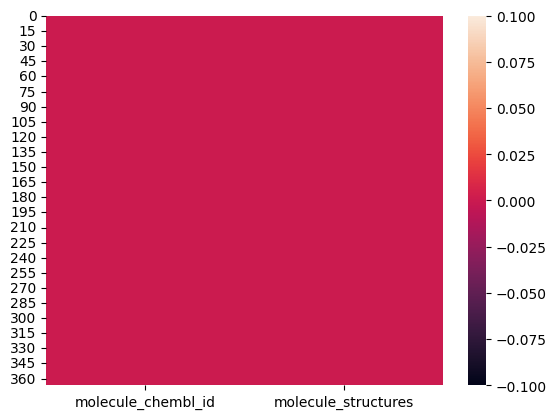

In [ ]:
#heatmap for checking missing entries
sns.heatmap(compounds_df.isnull())

1.remove missing entries

In [ ]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (367, 2)


2. delete molecules with duplicate entries

In [ ]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (367, 2)


3. obtain molecules with canonical smiles

In [ ]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [ ]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (367, 2)


compounds without canonical SMILES strings to be removed

In [ ]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (367, 2)


recheck missing data in the compounds DF

In [ ]:
compounds_df.isnull().sum()

molecule_chembl_id    0
smiles                0
dtype: int64

Bioactivity data and Compound data summary

In [ ]:

print(f"Bioactivities filtered: {hif_bioactivities_df2a.shape[0]}")
hif_bioactivities_df2a.columns

Bioactivities filtered: 367


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'type'],
      dtype='object')

In [ ]:
bioactivity_column_names=hif_bioactivities_df2a.columns
print('bioactivities column summary :',"\n",bioactivity_column_names)

bioactivities column summary : 
 Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'type'],
      dtype='object')


In [ ]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 367


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [ ]:
compound_column_names=compounds_df.columns
print('compound column summary :','\n',compound_column_names)

compound column summary : 
 Index(['molecule_chembl_id', 'smiles'], dtype='object')


merge  both bioactivity and compoud DF and rename DF

In [ ]:
compounds_df.head(3)

,molecule_chembl_id,smiles
0,CHEMBL84,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C...
1,CHEMBL283631,COc1cc([C@@H]2c3cc4c(cc3[C@@H](Nc3ccc([N+](=O)...
2,CHEMBL301982,CC1=C(O)C(=O)C=C2C1=CC=C1[C@@]2(C)CC[C@@]2(C)[...


In [ ]:
hif_bioactivities_df2a.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2007500,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL235553,=,nM,820.0,CHEMBL4261,Homo sapiens,IC50
1,2007503,CHEMBL901549,Inhibition of hypoxia-induced HIF1 activation ...,B,CHEMBL391152,=,nM,3400.0,CHEMBL4261,Homo sapiens,IC50
2,2048473,CHEMBL924308,Inhibition of hypoxia induced HIF1-alpha trans...,B,CHEMBL333985,=,nM,2000.0,CHEMBL4261,Homo sapiens,IC50


merge data frames keeping selected parameters

In [ ]:

output_df = pd.merge(
    hif_bioactivities_df2a[["molecule_chembl_id", "standard_value", "standard_units",]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 367 entries.


In [ ]:
output_df.head()

,molecule_chembl_id,standard_value,standard_units,canonical_smiles
0,CHEMBL235553,820.0,nM,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...
1,CHEMBL391152,3400.0,nM,CC1=C[C@@H](O)[C@@H]([C@H](C)CC[C@@H]2[C@@H](C...
2,CHEMBL333985,2000.0,nM,OCc1ccc(-c2nn(Cc3ccccc3)c3ccccc23)o1
3,CHEMBL399636,1030.0,nM,COC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)...
4,CHEMBL401390,11900.0,nM,NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...


rename data frame that has been merged




In [ ]:
hif_dfx=output_df
hif_dfx.head(3)

,molecule_chembl_id,standard_value,standard_units,smiles
0,CHEMBL235553,820.0,nM,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...
1,CHEMBL391152,3400.0,nM,CC1=C[C@@H](O)[C@@H]([C@H](C)CC[C@@H]2[C@@H](C...
2,CHEMBL333985,2000.0,nM,OCc1ccc(-c2nn(Cc3ccccc3)c3ccccc23)o1


In [ ]:
hif_dfx.shape

(367, 4)

In [ ]:
hif_dfx.rename(
    columns={'smiles':'canonical_smiles'},inplace=True
)

classifying and labelling compounds as ,
active, inactive  or intermediate

In [ ]:
bioactivity_class=[]
for i in hif_dfx.standard_value:
  if float (i) >=10000:
    bioactivity_class.append('inactive')
  elif float (i) <= 1000:
    bioactivity_class.append('active')
  else:
   bioactivity_class.append('intermediate')

iterate  molecule_chembl_id,   canonica_smiles,   standard_value to a list

In [ ]:
#chembl_id
mol_cid= hif_dfx['molecule_chembl_id']
mol_cid=[]
for i in hif_dfx.molecule_chembl_id:
  mol_cid.append(i)

In [ ]:
mol_cid

['CHEMBL235553',
 'CHEMBL391152',
 'CHEMBL333985',
 'CHEMBL399636',
 'CHEMBL401390',
 'CHEMBL250671',
 'CHEMBL248650',
 'CHEMBL249027',
 'CHEMBL248835',
 'CHEMBL403789',
 'CHEMBL249023',
 'CHEMBL430393',
 'CHEMBL373396',
 'CHEMBL249028',
 'CHEMBL219673',
 'CHEMBL248836',
 'CHEMBL603103',
 'CHEMBL603712',
 'CHEMBL602668',
 'CHEMBL604337',
 'CHEMBL601646',
 'CHEMBL601860',
 'CHEMBL223862',
 'CHEMBL603102',
 'CHEMBL603060',
 'CHEMBL84',
 'CHEMBL1271866',
 'CHEMBL1272037',
 'CHEMBL1271867',
 'CHEMBL1269467',
 'CHEMBL1271980',
 'CHEMBL1271924',
 'CHEMBL1269016',
 'CHEMBL1271978',
 'CHEMBL1271979',
 'CHEMBL1271868',
 'CHEMBL1269423',
 'CHEMBL1269397',
 'CHEMBL1272036',
 'CHEMBL1783622',
 'CHEMBL1783623',
 'CHEMBL1783624',
 'CHEMBL1783625',
 'CHEMBL1783626',
 'CHEMBL1783627',
 'CHEMBL1783628',
 'CHEMBL1783629',
 'CHEMBL1783631',
 'CHEMBL1782072',
 'CHEMBL1783633',
 'CHEMBL1783634',
 'CHEMBL1783635',
 'CHEMBL1783636',
 'CHEMBL1783637',
 'CHEMBL1783638',
 'CHEMBL380456',
 'CHEMBL1795451',
 'CHE

In [ ]:
canonical_smiles=[]
for i in hif_dfx.canonical_smiles:
  canonical_smiles.append(i)

In [ ]:
canonical_smiles

['CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](C)[C@@]3(C)CC[C@]2(C)O3)CC1',
 'CC1=C[C@@H](O)[C@@H]([C@H](C)CC[C@@H]2[C@@H](C)[C@@]3(C)CC[C@]2(C)O3)CC1',
 'OCc1ccc(-c2nn(Cc3ccccc3)c3ccccc23)o1',
 'COC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C4)cc2)c1',
 'NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C4)cc2)c1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cncc(C(=O)NCCCn2ccnc2)c1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cncc(C(=O)NCc2ccco2)c1',
 'NC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C4)cc2)c1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cc(C(=O)Nc2ccc(Cl)cc2)ccn1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cc(C(=O)NCCCn2ccnc2)ccn1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cc(C(=O)NCCc2ccncc2)ccn1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cc(C(=O)O)ccn1',
 'COC(=O)c1cccc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C4)cc2)c1',
 'COC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C4)cc2)c1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cccc(C(=O)O)c1',
 'O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1c

In [ ]:
standard_value=[]
for i in hif_dfx.standard_value:
  standard_value.append(i)

In [ ]:
standard_value

[820.0,
 3400.0,
 2000.0,
 1030.0,
 11900.0,
 1900.0,
 4100.0,
 600.0,
 2500.0,
 900.0,
 3400.0,
 2000.0,
 2600.0,
 5900.0,
 400.0,
 1300.0,
 90600.0,
 91800.0,
 70400.0,
 35300.0,
 84800.0,
 40300.0,
 3100.0,
 3100.0,
 4600.0,
 60.0,
 800.0,
 1400.0,
 1500.0,
 1500.0,
 1500.0,
 1800.0,
 2000.0,
 2000.0,
 3500.0,
 4000.0,
 5500.0,
 6000.0,
 8000.0,
 32700.0,
 69900.0,
 35500.0,
 17400.0,
 52100.0,
 23000.0,
 51700.0,
 41600.0,
 32500.0,
 7210.0,
 39100.0,
 18700.0,
 8620.0,
 29600.0,
 22100.0,
 15100.0,
 10700.0,
 17600.0,
 17500.0,
 17200.0,
 16800.0,
 5300.0,
 12900.0,
 7300.0,
 2600.0,
 26200.0,
 6.76,
 1.0,
 1100.0,
 360.0,
 310.0,
 54.0,
 110.0,
 7.0,
 580.0,
 490.0,
 54.0,
 4.2,
 46.0,
 10.0,
 10.7,
 6.76,
 9400.0,
 1700.0,
 27600.0,
 470.0,
 160.0,
 90.0,
 1200.0,
 27600.0,
 27500.0,
 430.0,
 810.0,
 3300.0,
 200.0,
 4200.0,
 4100.0,
 22900.0,
 6200.0,
 3500.0,
 1850.0,
 1070.0,
 1340.0,
 120.0,
 1350.0,
 2620.0,
 1840.0,
 820.0,
 2380.0,
 1180.0,
 4120.0,
 2170.0,
 1040.0,
 603

combine the list [mol_cid, canonical_smiles, bioactivity_class_standard_value] into DF

In [ ]:
data_tuples=list(zip(mol_cid,canonical_smiles,bioactivity_class,standard_value))
dfx=pd.DataFrame(data_tuples,columns=['molecule_chembl_id','canonical_smiles','bioactivity_class','standard_value'])

In [ ]:
dfx

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL235553,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...,active,820.0
1,CHEMBL391152,CC1=C[C@@H](O)[C@@H]([C@H](C)CC[C@@H]2[C@@H](C...,intermediate,3400.0
2,CHEMBL333985,OCc1ccc(-c2nn(Cc3ccccc3)c3ccccc23)o1,intermediate,2000.0
3,CHEMBL399636,COC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)...,intermediate,1030.0
4,CHEMBL401390,NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,inactive,11900.0
...,...,...,...,...
362,CHEMBL5174696,COC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,200.0
363,CHEMBL5197796,O=C(Nc1ccc2scnc2c1)c1noc2ccccc12,active,42.0
364,CHEMBL5190853,O=C1CCCc2cc(NC(=O)c3noc4ccccc34)ccc21,active,640.0
365,CHEMBL5209002,CC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,640.0


Calculate the descriptors

In [ ]:
#from: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors


In [ ]:
df_lipinski =lipinski(dfx.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,306.490,4.7136,1.0,2.0
1,306.490,4.7136,1.0,2.0
2,304.349,3.8369,1.0,4.0
3,420.509,4.3535,1.0,5.0
4,405.498,3.6658,2.0,4.0
...,...,...,...,...
362,296.282,2.8667,1.0,5.0
363,295.323,3.6898,1.0,5.0
364,306.321,3.5991,1.0,4.0
365,280.283,3.2827,1.0,4.0


In [ ]:
df_combined=pd.concat([dfx,df_lipinski],axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL235553,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...,active,820.0,306.490,4.7136,1.0,2.0
1,CHEMBL391152,CC1=C[C@@H](O)[C@@H]([C@H](C)CC[C@@H]2[C@@H](C...,intermediate,3400.0,306.490,4.7136,1.0,2.0
2,CHEMBL333985,OCc1ccc(-c2nn(Cc3ccccc3)c3ccccc23)o1,intermediate,2000.0,304.349,3.8369,1.0,4.0
3,CHEMBL399636,COC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)...,intermediate,1030.0,420.509,4.3535,1.0,5.0
4,CHEMBL401390,NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,inactive,11900.0,405.498,3.6658,2.0,4.0
...,...,...,...,...,...,...,...,...
362,CHEMBL5174696,COC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,200.0,296.282,2.8667,1.0,5.0
363,CHEMBL5197796,O=C(Nc1ccc2scnc2c1)c1noc2ccccc12,active,42.0,295.323,3.6898,1.0,5.0
364,CHEMBL5190853,O=C1CCCc2cc(NC(=O)c3noc4ccccc34)ccc21,active,640.0,306.321,3.5991,1.0,4.0
365,CHEMBL5209002,CC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,640.0,280.283,3.2827,1.0,4.0


distribution of standard_value (IC50)

standard_value (IC50)distribution


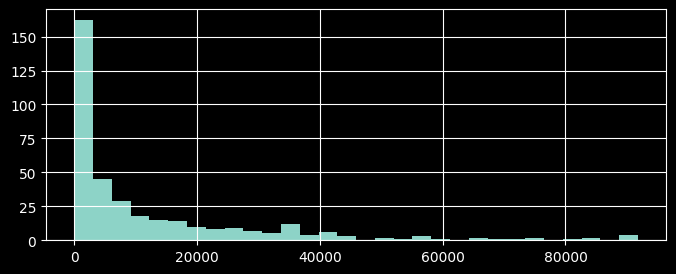

In [ ]:
print('standard_value (IC50)distribution')
plt.style.use('dark_background')
plt.rcParams['figure.figsize']=(8,3)
df_combined['standard_value'].hist(bins=30)
plt.show()

 IC50 to PIC50 Transformation:


-IC50 reported in standard_value column has uneven distribution data

-large values will be capped to 100 000 000 so that the large value do not become negative  after transformation

-standard_values are converted to negative logarithmic scale

In [ ]:
def capping_large_values (item):
  if item >100000000:
    return 100000000
  else:
      return item


In [ ]:
df_combined['standard_value']=df_combined['standard_value'].apply(capping_large_values)

checking values that needed capping

In [ ]:
len(df_combined.loc[df_combined['standard_value']==100000000]) #checking values that needed capping,none needed capping

0

In [ ]:
def neg_log_transformation(item):
  item=item*(10**-9)
  return -np.log10(item)

In [ ]:
df_combined['standard_value_transformed']=df_combined['standard_value'].apply(neg_log_transformation)

In [ ]:
df_combined[df_combined['standard_value_transformed']<0]

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed


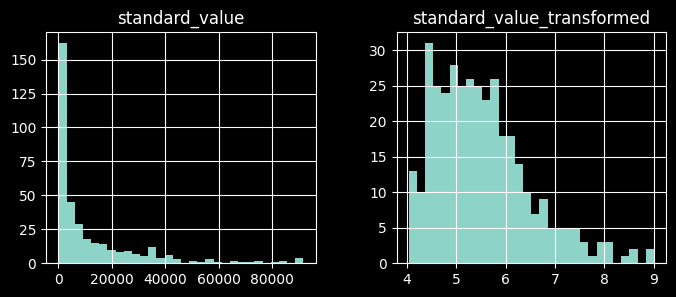

In [ ]:

plt.style.use('dark_background')
plt.rcParams['figure.figsize']=(8,3)
df_combined[['standard_value','standard_value_transformed']].hist(bins=30)
plt.show()

In [ ]:
df_combined.head(5)

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed
0,CHEMBL235553,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...,active,820.0,306.490,4.7136,1.0,2.0,6.086186
1,CHEMBL391152,CC1=C[C@@H](O)[C@@H]([C@H](C)CC[C@@H]2[C@@H](C...,intermediate,3400.0,306.490,4.7136,1.0,2.0,5.468521
2,CHEMBL333985,OCc1ccc(-c2nn(Cc3ccccc3)c3ccccc23)o1,intermediate,2000.0,304.349,3.8369,1.0,4.0,5.698970
3,CHEMBL399636,COC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)...,intermediate,1030.0,420.509,4.3535,1.0,5.0,5.987163
4,CHEMBL401390,NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,inactive,11900.0,405.498,3.6658,2.0,4.0,4.924453


 -function that converts IC50  to PIC50




In [ ]:
def convert_ic50_to_pic50(IC50_value):
  pic50_value=9 -math.log10(IC50_value)
  return pic50_value

In [ ]:
convert_ic50_to_pic50(1)

9.0

In [ ]:
convert_ic50_to_pic50(1000)

6.0

In [ ]:
convert_ic50_to_pic50(10000)

5.0

In [ ]:
convert_ic50_to_pic50(820)

6.086186147616283

In [ ]:
convert_ic50_to_pic50(3400)

5.468521082957745

In [ ]:
convert_ic50_to_pic50(11900)

4.924453038607469

rename columns:

-standard_value: IC50

-standard_vaue_transformed:pIC50

In [ ]:

df_combined.rename(
    columns ={'standard_value':'IC50','standard_value_transformed':'pIC50'},inplace=True
    )

In [ ]:
df_combined

,molecule_chembl_id,canonical_smiles,bioactivity_class,IC50,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL235553,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...,active,820.0,306.490,4.7136,1.0,2.0,6.086186
1,CHEMBL391152,CC1=C[C@@H](O)[C@@H]([C@H](C)CC[C@@H]2[C@@H](C...,intermediate,3400.0,306.490,4.7136,1.0,2.0,5.468521
2,CHEMBL333985,OCc1ccc(-c2nn(Cc3ccccc3)c3ccccc23)o1,intermediate,2000.0,304.349,3.8369,1.0,4.0,5.698970
3,CHEMBL399636,COC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)...,intermediate,1030.0,420.509,4.3535,1.0,5.0,5.987163
4,CHEMBL401390,NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,inactive,11900.0,405.498,3.6658,2.0,4.0,4.924453
...,...,...,...,...,...,...,...,...,...
362,CHEMBL5174696,COC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,200.0,296.282,2.8667,1.0,5.0,6.698970
363,CHEMBL5197796,O=C(Nc1ccc2scnc2c1)c1noc2ccccc12,active,42.0,295.323,3.6898,1.0,5.0,7.376751
364,CHEMBL5190853,O=C1CCCc2cc(NC(=O)c3noc4ccccc34)ccc21,active,640.0,306.321,3.5991,1.0,4.0,6.193820
365,CHEMBL5209002,CC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,640.0,280.283,3.2827,1.0,4.0,6.193820


remove intermediate bioactivity class

In [ ]:
df_final=df_combined[df_combined.bioactivity_class!='intermediate']
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,IC50,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL235553,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...,active,820.0,306.490,4.7136,1.0,2.0,6.086186
4,CHEMBL401390,NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,inactive,11900.0,405.498,3.6658,2.0,4.0,4.924453
7,CHEMBL249027,NC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,active,600.0,405.498,3.6658,2.0,4.0,6.221849
9,CHEMBL403789,O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cc(C(=...,active,900.0,513.642,4.5835,2.0,6.0,6.045757
14,CHEMBL219673,O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cccc(C...,active,400.0,405.494,4.8701,2.0,3.0,6.397940
...,...,...,...,...,...,...,...,...,...
362,CHEMBL5174696,COC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,200.0,296.282,2.8667,1.0,5.0,6.698970
363,CHEMBL5197796,O=C(Nc1ccc2scnc2c1)c1noc2ccccc12,active,42.0,295.323,3.6898,1.0,5.0,7.376751
364,CHEMBL5190853,O=C1CCCc2cc(NC(=O)c3noc4ccccc34)ccc21,active,640.0,306.321,3.5991,1.0,4.0,6.193820
365,CHEMBL5209002,CC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,640.0,280.283,3.2827,1.0,4.0,6.193820


add rdkit column
-sort molecules by pIC50 values

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df_final,smilesCol='canonical_smiles')

,molecule_chembl_id,canonical_smiles,bioactivity_class,IC50,MW,LogP,NumHDonors,NumHAcceptors,pIC50,ROMol
0,CHEMBL235553,CC1=C[C@@H](O)[C@@H]([C@@H](C)CC[C@@H]2[C@@H](...,active,820.0,306.490,4.7136,1.0,2.0,6.086186,
4,CHEMBL401390,NC(=O)c1cncc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,inactive,11900.0,405.498,3.6658,2.0,4.0,4.924453,
7,CHEMBL249027,NC(=O)c1ccnc(NC(=O)COc2ccc(C34CC5CC(CC(C5)C3)C...,active,600.0,405.498,3.6658,2.0,4.0,6.221849,
9,CHEMBL403789,O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cc(C(=...,active,900.0,513.642,4.5835,2.0,6.0,6.045757,
14,CHEMBL219673,O=C(COc1ccc(C23CC4CC(CC(C4)C2)C3)cc1)Nc1cccc(C...,active,400.0,405.494,4.8701,2.0,3.0,6.397940,
...,...,...,...,...,...,...,...,...,...,...
362,CHEMBL5174696,COC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,200.0,296.282,2.8667,1.0,5.0,6.698970,
363,CHEMBL5197796,O=C(Nc1ccc2scnc2c1)c1noc2ccccc12,active,42.0,295.323,3.6898,1.0,5.0,7.376751,
364,CHEMBL5190853,O=C1CCCc2cc(NC(=O)c3noc4ccccc34)ccc21,active,640.0,306.321,3.5991,1.0,4.0,6.193820,
365,CHEMBL5209002,CC(=O)c1cccc(NC(=O)c2noc3ccccc23)c1,active,640.0,280.283,3.2827,1.0,4.0,6.193820,

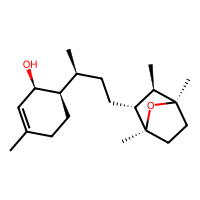
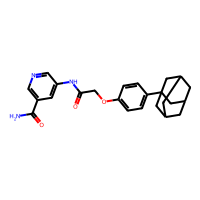
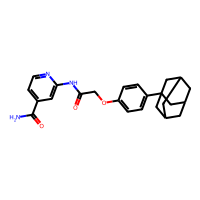
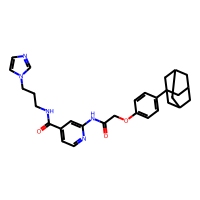
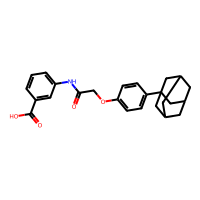
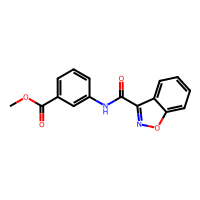
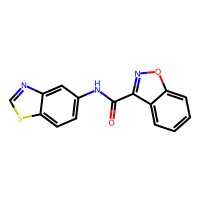
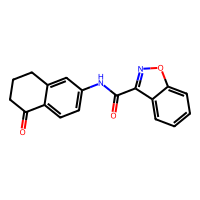
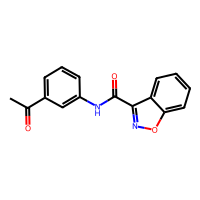
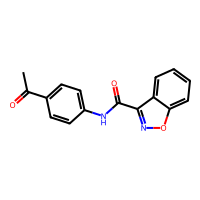

In [ ]:
df_final

 save bioactivity data to a CSV

In [ ]:

df_final.to_csv('bioactivity_data.csv', index=False)

 copy files to Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


In [ ]:

! mkdir "/content/gdrive/My Drive/Colab Notebooks/data126"

In [ ]:
! cp bioactivity_data.csv "/content/gdrive/My Drive/Colab Notebooks/data"

  Description  of the data in the Bioactivity Data Frame

In [ ]:
df_final.describe()

,IC50,MW,LogP,NumHDonors,NumHAcceptors,pIC50
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,18084.937647,442.334376,5.009430,1.583710,5.199095,5.533388
std,21738.766992,131.635023,2.246205,1.065367,1.738913,1.218826
min,1.000000,211.198000,-1.014100,0.000000,2.000000,4.037157
25%,360.000000,338.403000,3.335400,1.000000,4.000000,4.559091
50%,12800.000000,404.400000,4.472300,1.000000,5.000000,4.892790
75%,27600.000000,566.846000,6.752900,2.000000,6.000000,6.443697
max,91800.000000,763.909000,9.567970,4.000000,12.000000,9.000000


EXPLORATORY DATA ANLYSIS

Frequency plots for active and inactive bioactivity classes

In [ ]:

import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

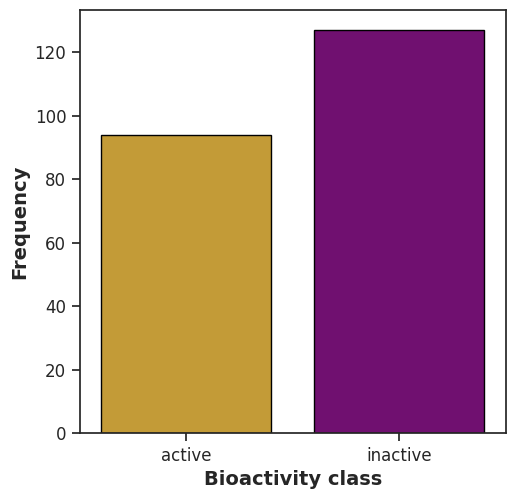

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_final, palette = ["goldenrod", "purple"], edgecolor='black',hue='bioactivity_class',legend=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('plot_bioactivity_class.pdf')

Scatter plot for Molecular Weight (MW) vs LogP

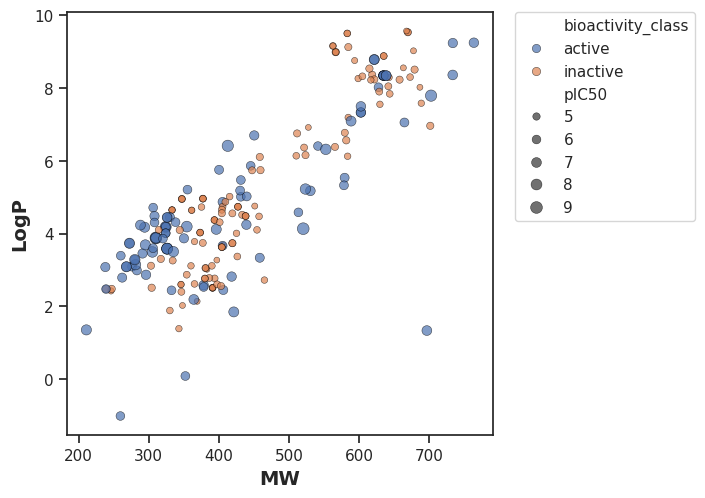

In [ ]:


plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

BOXPLOTS AND STATISTICAL ANALYSIS



STATISTICAL ANALYSIS

MannWhitney U-test

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

BOXPLOTS

Molecular Weight(MW)

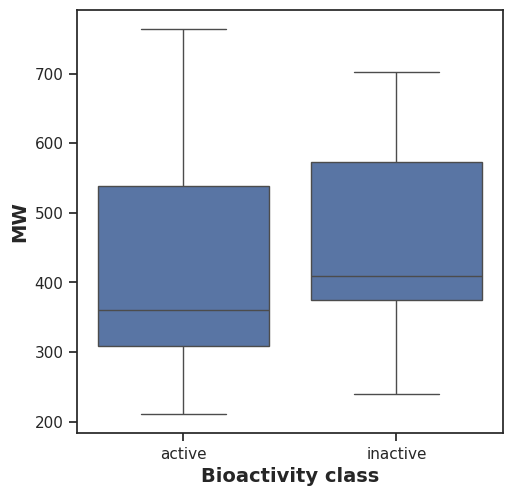

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')




In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,4492.5,0.001685,0.05,Different distribution (reject H0)


NumHDonors

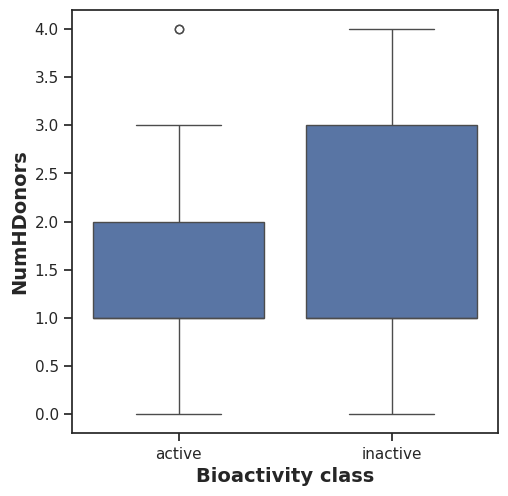

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,4644.0,0.00281,0.05,Different distribution (reject H0)


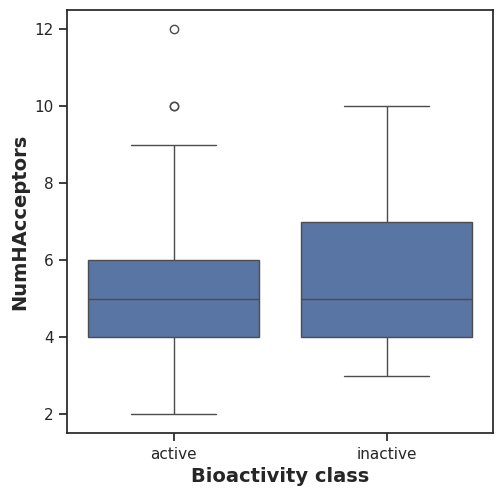

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,5591.0,0.413922,0.05,Same distribution (fail to reject H0)


LogP

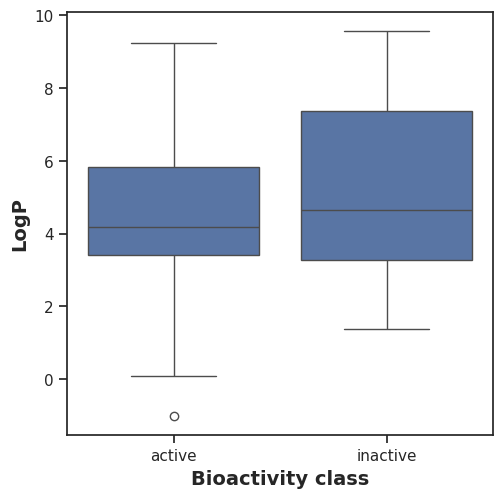

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,5335.5,0.177987,0.05,Same distribution (fail to reject H0)


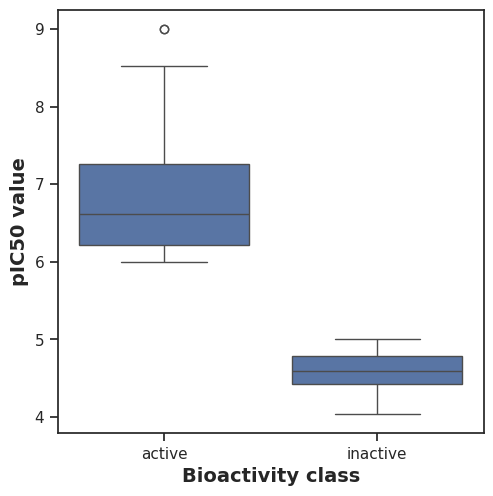

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,11938.0,5.872463e-37,0.05,Different distribution (reject H0)


Summary

-bioactivity data of the target of interest (hypoxia inducible factor1 alpha) was collected

-data was preprocessed, filtered to obtain compounds   that measured IC50 bioactivity values

-bioactivity of compounds  was classified as either being, active, inactive or intermediate

-compounds with IC50  value of less than 1000nM =Active, ( pIC50 >6)

-compounds with IC50 value that is greater than 10 000 nM= Inactive,(pIC50<5)

-for further analysis  intermediate bioactivity class was dropped,

-compounds were finally classified as beiing active or inactive





MANNWHITNEY STATISTICAL RESULTS

-for pIC50 values , there was statistical significant difference between active and nonactive bioactivity compounds



-for Lipkinski descriptors(MW,NumHDonors), there was also statitical significant difference between active and inactive bioactivity compounds

-for LogP  and NumHAcceptors descriptors  there was no statisitical difference between active and inactive biaoctivity compounds



zip files

In [ ]:
! zip -r results3.zip . -i *.csv *.pdf

Scanning files 
updating: plot_LogP.pdf (deflated 37%)
updating: mannwhitneyu_NumHDonors.csv (deflated 11%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
updating: plot_NumHAcceptors.pdf (deflated 37%)
updating: mannwhitneyu_MW.csv (deflated 8%)
updating: plot_ic50.pdf (deflated 37%)
updating: mannwhitneyu_pIC50.csv (deflated 10%)
updating: plot_NumHDonors.pdf (deflated 38%)
updating: plot_bioactivity_class.pdf (deflated 38%)
updating: mannwhitneyu_LogP.csv (deflated 7%)
updating: plot_MW_vs_LogP.pdf (deflated 10%)
updating: plot_MW.pdf (deflated 38%)
  adding: bioactivity_data.csv (deflated 79%)
